# Text semplification project

## Transformer model trained with supervised approach


**Authors**: 

*   Davide Mercanti: davide.mercanti@studio.unibo.it
*   Riccardo Fava: riccardo.fava6@studio.unibo.it
*   Luca Bompani: luca.bompani4@studio.unibo.it

## Configuration

In [ ]:
from utilities import resize
resize(100)

# Installing third part libraries
!pip install fasttext > /dev/null
!pip install "tensorflow-text==2.8.*" > /dev/null   
!pip install datasets > /dev/null
!pip install sacrebleu > /dev/null
!pip install sacremoses > /dev/null

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
try:
    from keras.preprocessing.sequence import pad_sequences
except ImportError:
    from keras.utils import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
import fasttext
import fasttext.util
import matplotlib.pyplot as plt
import pickle 
import typing
import random
from datasets import load_metric
from typing import Any, Tuple
import tensorflow_text as tf_text
from os.path import join, dirname
try:
    from google.colab import drive
    COLAB = True
except ModuleNotFoundError:
    COLAB = False

from data_cleaning import clean_data
from data_preparation import build_vocabulary
    
from utilities import memoization, plot_trend

@memoization(0)
def word_tk_mem(arg):
    return word_tokenize(arg)

nltk.download('punkt')
if COLAB:
    drive.mount('/content/drive')
    PATH = '/content/drive/MyDrive/UniBO/NLP'
else:
    PATH = './'
use_builtins = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


## Pre-processing

In [3]:
df = clean_data(PATH)
df.dropna(inplace=True)
df.head(15)

DF 1 has shape (63006, 2)
DF 2 has shape (1166, 2)


,sentence_1,sentence_2
0,ma questo a cosa servirebbe ?,a che servono queste cose ?
1,"salve, avrei bisogno di una informazione piutt...",ho bisogno di una informazione urgente .
2,ciao a tutti avrei bisogno di un consiglio .,ho bisogno di un suo consiglio .
3,possibilmente uno che avesse bisogno dell aiuto .,ho bisogno di un vostro aiuto .
4,questa sarebbe una cosa positiva.,questa era una nuova cosa .
5,possibilmente uno che avesse bisogno dell aiuto .,ho bisogno di un aiuto .
6,avrei bisogno di un aiuto .,ho bisogno di un vostro aiuto .
7,quale sarebbe allora la soluzione giusta ?,è questa la soluzione giusta ?
8,"salve , avrei bisogno di un vostro aiuto .",abbiamo bisogno del vostro aiuto .
9,"salve , avrei bisogno di un vostro aiuto .",ho bisogno del vostro aiuto .


In [4]:
TRAIN_DF, TEST_DF = train_test_split(df, test_size=0.3)

In [5]:
def build_vocabulary(train_df, test_df, tokenizer):
    """
    Given train corpus and test corpus, builds the corresponding word vocabulary.

    --------------
    Return: 
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """

    corpus = list(pd.concat([
        train_df['sentence_1'],
        train_df['sentence_2'],
        test_df['sentence_1'],
        test_df['sentence_2']
    ]))
    word_to_idx = dict()  
    idx_to_word = dict()
    word_listing = set()

    # Get all unique words in corpus 
    for sentence in corpus:
        word_listing |= set(tokenizer(sentence))
        
   # Cast to list
    word_listing = list(word_listing)

    # Build vocabulary index to word <idx : word>
    idx_to_word = dict(enumerate(word_listing, start=1))
    idx_to_word[len(idx_to_word)+1] = "[start]"
    idx_to_word[len(idx_to_word)+1] = "[end]"

    # Build word_to_idx <word : idx>
    word_to_idx = dict({_:k for k,_ in idx_to_word.items()})

    return idx_to_word, word_to_idx, word_listing

In [6]:
IDX_TO_WORD, WORD_TO_IDX, WORD_LISTING = build_vocabulary(TRAIN_DF, TEST_DF, word_tk_mem)
VOCAB_SIZE = len(IDX_TO_WORD)
print(VOCAB_SIZE)

17978


## Load Pre-trained Word embedding model

In [7]:
# We load the pretrained FastText model

EMBEDD_DIM = 200

EMBEDD_FNAME = f'cc.it.{EMBEDD_DIM}.bin'  #ex. 'cc.it.100.bin'

try: EMBEDDING_MODEL
except NameError:
    # Downloading FastText italian pre-trained model
    fasttext.FastText.eprint = lambda x: None
    try:
        print('Loading fasttext model...', flush=True)
        EMBEDDING_MODEL = fasttext.load_model(join(PATH, EMBEDD_FNAME))
    except ValueError as e:
        print(e)
        fasttext.util.download_model('it', if_exists='ignore')  
        EMBEDDING_MODEL = fasttext.load_model(join(PATH, EMBEDD_FNAME))

print(EMBEDDING_MODEL.get_dimension())

Loading fasttext model...
200


In [8]:
def check_OOV_terms(embedding_model, vocabulary_terms):
  '''Returns a list of out-of-vocabulary (OOV) terms and the corresp. len'''
  oov = set(vocabulary_terms).difference(set(embedding_model.words))
  return list(oov), len(oov)

In [9]:
_, n_oov_terms = check_OOV_terms(EMBEDDING_MODEL, WORD_LISTING)
print(f"Total OOV terms: {n_oov_terms} ({n_oov_terms*100/len(WORD_LISTING):.03f}%)")

Total OOV terms: 1274 (7.087%)


In [10]:
EMBEDDING_DIM = EMBEDDING_MODEL.get_dimension()

def compute_embedding_matrix(embedding_model, idx_to_word):
  """
  Return the embedding matrix of the train vocabulary:
  """
  embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM), dtype='float32')

  for idx in idx_to_word.keys():
    embedding_matrix[idx] = embedding_model.get_word_vector(idx_to_word[idx])
  return embedding_matrix

EMBEDDING_MATRIX = compute_embedding_matrix(EMBEDDING_MODEL, IDX_TO_WORD)

In [11]:
print(f'Weights matrix size: {EMBEDDING_MATRIX.shape}')
print(f'Vocab size: {VOCAB_SIZE}')

Weights matrix size: (17979, 200)
Vocab size: 17978


In [12]:
def word_to_idx_conversion(df, word_to_idx, len_sentence=None): 
  """
  Return input data (sentences) encoded
  
  Parameters
  ----------
  - corpus (train or test dataframe)

  Return
  ------
  - DataFrame: sentences encoded using the word_to_idx dict
  """
  # Conversion
  converted_df = df.applymap(lambda _: [word_to_idx[token] for token in word_tk_mem(_)])
  # Add "[start] token at the first position of the sentence"
  converted_df['sentence_2'] = converted_df['sentence_2'].map(lambda _: [word_to_idx["[start]"]] + _)
  # Add "[end] token at the last position of the sentence"
  converted_df['sentence_2'] = converted_df['sentence_2'].map(lambda _: _ + [word_to_idx["[end]"]])

  return converted_df

ENCODED_TRAIN_DF = word_to_idx_conversion(TRAIN_DF, WORD_TO_IDX)
m_len_input = max([len(i) for i in ENCODED_TRAIN_DF['sentence_1']])
ENCODED_TEST_DF = word_to_idx_conversion(TEST_DF, WORD_TO_IDX, len_sentence=m_len_input)
print(ENCODED_TRAIN_DF.shape, ENCODED_TEST_DF.shape)
ENCODED_TRAIN_DF.head(3)

(44918, 2) (19251, 2)


,sentence_1,sentence_2
16105,"[2759, 16687, 12002, 3265, 2743, 5993, 16327, ...","[17977, 2759, 16687, 12002, 3265, 5993, 16327,..."
61303,"[14662, 11910, 11147, 1792, 639, 1120, 6224, 1...","[17977, 6814, 14662, 11910, 1792, 639, 1120, 6..."
33781,"[7242, 14662, 11910, 978, 17711, 7005, 6255, 7...","[17977, 14662, 2557, 7005, 6255, 978, 7525, 17..."


In [13]:
def pad_sentences(train_df, test_df):
  """
  Returns zip objects containing pairs of complex and simplified sentences
  padded according to the value MAX_SEQ_LENGTH (computed in order to handle
  the majority of our data). Perform this operation for train, validation
  and test set.
  """
  cplx_train = [list(i) for i in train_df['sentence_1'].values] 
  smpl_train = [list(i) for i in train_df['sentence_2'].values]
  cplx_test = [list(i) for i in test_df['sentence_1'].values] 
  smpl_test = [list(i) for i in test_df['sentence_2'].values]
  # Computing padding size in order to handle the majority of our data (95-99%)
  max_seq_length = int(np.quantile([len(seq) for seq in cplx_train + smpl_train + cplx_test + smpl_test], 0.99))
  # Ceation of the validation set
  cplx_test, cplx_valid, smpl_test, smpl_valid = train_test_split(cplx_test, smpl_test, test_size=0.3, random_state=42)
  # Apply padding
  cplx_train = pad_sequences(cplx_train, padding="post", maxlen=max_seq_length)
  smpl_train = pad_sequences(smpl_train, padding="post", maxlen=max_seq_length + 1)
  cplx_test = pad_sequences(cplx_test, padding="post", maxlen=max_seq_length)
  smpl_test = pad_sequences(smpl_test, padding="post", maxlen=max_seq_length + 1)
  cplx_valid = pad_sequences(cplx_valid, padding="post", maxlen=max_seq_length)
  smpl_valid = pad_sequences(smpl_valid, padding="post", maxlen=max_seq_length + 1)
  return tuple(zip(cplx_train, smpl_train)), tuple(zip(cplx_test, smpl_test)), tuple(zip(cplx_valid, smpl_valid)), max_seq_length

TRAIN_PAIRS, TEST_PAIRS, VALID_PAIRS, MAX_SEQ_LENGHT = pad_sentences(ENCODED_TRAIN_DF, ENCODED_TEST_DF)
print(f"Max_sequence_lenght: {MAX_SEQ_LENGHT}")

Max_sequence_lenght: 35


In [14]:
BATCH_SIZE = 64

def format_dataset(cplx, simpl):
  return ({"encoder_inputs": cplx, "decoder_inputs": simpl[:, :-1],}, simpl[:, 1:])

def make_dataset(pairs, batch_size): 
  """
  Build dataset objects for train, validation and test set
  
  """
  complex_sent, simpl_sent = zip(*pairs)
  dataset = tf.data.Dataset.from_tensor_slices((list(complex_sent), list(simpl_sent)))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset)
  return dataset.shuffle(2048).prefetch(16).cache()

TRAIN_DATASET = make_dataset(TRAIN_PAIRS, BATCH_SIZE)
TEST_DATASET = make_dataset(TEST_PAIRS, BATCH_SIZE)
VALID_DATASET = make_dataset(VALID_PAIRS, BATCH_SIZE)

In [15]:
for inputs, targets in TRAIN_DATASET.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 35)
inputs["decoder_inputs"].shape: (64, 35)
targets.shape: (64, 35)


## Defining model and utility functions

In [16]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, initializer, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        if initializer != "uniform":
          self.token_embeddings = layers.Embedding(
              input_dim=vocab_size, output_dim=embed_dim, embeddings_initializer=initializer, mask_zero=True)
        else:
            self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, embeddings_initializer=initializer)

        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [17]:
def get_model(initializer = "uniform", latent_dim = 2048, num_heads = 8):
  """
  Return the model built using the inserted hyper-parameters
  
  """
  global MAX_SEQ_LENGHT, VOCAB_SIZE, EMBEDDING_DIM
  encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
  x = PositionalEmbedding(MAX_SEQ_LENGHT, VOCAB_SIZE+1, EMBEDDING_DIM, initializer)(encoder_inputs)
  encoder_outputs = TransformerEncoder(EMBEDDING_DIM, latent_dim, num_heads)(x)
  encoder = keras.Model(encoder_inputs, encoder_outputs)

  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
  encoded_seq_inputs = keras.Input(shape=(None, EMBEDDING_DIM), name="decoder_state_inputs")
  x = PositionalEmbedding(MAX_SEQ_LENGHT, VOCAB_SIZE+1, EMBEDDING_DIM, initializer)(decoder_inputs)
  x = TransformerDecoder(EMBEDDING_DIM, latent_dim, num_heads)(x, encoded_seq_inputs)
  x = layers.Dropout(0.5)(x)
  decoder_outputs = layers.Dense(VOCAB_SIZE+1, activation="softmax")(x)
  decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

  decoder_outputs = decoder([decoder_inputs, encoder_outputs])
  return keras.Model(
      [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")


In [18]:
def save_vocab_data(vocab_data_path):
  """
  Save Embedding Matrix, vocabulary and vocab_dictionaries
  
  """
  try:
    # Save the data
    filename = join(vocab_data_path, 'word_to_idx.p')
    with open(filename, 'wb') as outfile:
        pickle.dump(WORD_TO_IDX, outfile)
    filename = join(vocab_data_path, 'idx_to_word.p')
    with open(filename, 'wb') as outfile:
        pickle.dump(IDX_TO_WORD, outfile)
    filename = join(vocab_data_path, 'word_listing.p')
    with open(filename, 'wb') as outfile:
        pickle.dump(WORD_LISTING, outfile)
    filename = join(vocab_data_path, 'embedding_matrix.p')
    with open(filename, 'wb') as outfile:
      pickle.dump(EMBEDDING_MATRIX, outfile)
    print("Data saved!")
  except Exception:
    print('**NOT** saved!')

In [19]:
def decode_sequence(model, input_sentence, idx_to_word, word_to_idx):
  """
  Performs the decoding of the sequence predicted from the model

  """
  tokenized_input_sentence = np.array(input_sentence).reshape((1,-1))
  tokenized_input_sentence = tf.convert_to_tensor(tokenized_input_sentence)
  decoded_sentence = "[start]"

  for i in range(MAX_SEQ_LENGHT):
      tokenized_target_sentence = np.array([word_to_idx[token] for token in decoded_sentence.split(" ")]).reshape((1,-1))
      tokenized_target_sentence = pad_sequences(tokenized_target_sentence, padding="post", maxlen=MAX_SEQ_LENGHT)
      tokenized_target_sentence = tf.convert_to_tensor(tokenized_target_sentence)
      predictions = model([tokenized_input_sentence, tokenized_target_sentence])
      sampled_token_index = np.argmax(predictions[0, i, :])
      sampled_token = idx_to_word[sampled_token_index]
      decoded_sentence += " " + sampled_token
      if sampled_token == "[end]":
          break
  return decoded_sentence

def convert_seq_to_text(input_sentence, idx_to_word):
  """
  Convert a sequence of token indexes into text

  """
  result = ""
  for token in input_sentence:
    if token != 0:
      result += idx_to_word[token] + " "
  return result

In [20]:
def evaluate_model(model, test_pairs, tokenizer):
  """
  Performs the evaluation of the model computing the BLEU and SARI metrics

  """
  global IDX_TO_WORD, WORD_TO_IDX
  test_texts = [pair[0] for pair in test_pairs]
  bleu_metric = load_metric("bleu")
  sari_metric = load_metric("sari")
  bleu_pred, bleu_ref = [], []
  sari_pred, sari_ref, sari_sources = [], [], []

  for input_sentence in test_texts:
  #for input_sentence in test_texts[:1000]:
    translated_sentence = decode_sequence(model, input_sentence, IDX_TO_WORD, WORD_TO_IDX)
    # Removing [start] and [end] tags
    translated_sentence = translated_sentence.replace("[start] ", '')
    translated_sentence = translated_sentence.replace(" [end]", '')
    # BLEU
    bleu_pred.append([token for token in tokenizer(translated_sentence)])
    bleu_ref.append([[token for token in tokenizer(convert_seq_to_text(input_sentence, IDX_TO_WORD))]])
    # SARI
    sari_pred.append(translated_sentence)
    sari_sources.append(convert_seq_to_text(input_sentence, IDX_TO_WORD))
    sari_ref.append([convert_seq_to_text(input_sentence, IDX_TO_WORD)])

  # Computing metrics
  bleu_score = bleu_metric.compute(predictions=bleu_pred, references = bleu_ref)
  sari_score = sari_metric.compute(sources=sari_sources, predictions=sari_pred, references=sari_ref)
  return bleu_score, sari_score

## Hyperparameters tuning

In [21]:
def tune_hyperparms(params_dict, epochs):
  """
  Performs the hyper-parameter tuning searching for the best configuration

  """
  global TRAIN_DATASET, VALID_DATASET, VALID_PAIRS, word_tk_mem
  results = pd.DataFrame(columns=list(params_dict.keys()) + ["SARI"] + ["BLEU"])
  try:
    for latent_dim in params_dict['latent_dim']:
      for heads in params_dict['n_heads']:
        for LR in params_dict['learning_rate']:
          initializer = keras.initializers.Constant(EMBEDDING_MATRIX)
          transformer = get_model(initializer, latent_dim, heads)
          callbacks = [
              EarlyStopping(patience=3, verbose=1),
              ReduceLROnPlateau(factor=0.1, patience=3, verbose=0)]
          transformer.compile(Adam(learning_rate = LR), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
          print(f"LR = {LR} | Latent_dimension = {latent_dim} | Number of heads = {heads}")
          history = transformer.fit(TRAIN_DATASET, 
                                    epochs=epochs, 
                                    validation_data=VALID_DATASET,
                                    callbacks=callbacks,
                                    verbose=0)
          bleu_score, sari_score = evaluate_model(transformer, VALID_PAIRS, word_tk_mem)
          print(f"BLEU score: {round(bleu_score['bleu'], 3)}, SARI score: {round(sari_score['sari'], 3)}\n")
          results = results.append({"learning_rate": LR, "latent_dim": latent_dim, "SARI": round(sari_score['sari'], 3),\
                                                "BLEU": round(bleu_score['bleu'], 3)}, ignore_index=True)
  except KeyboardInterrupt:
    print('\n === Manually aborted, returning results so far. ===')
  finally:
    return results

In [ ]:
params_dict = {
      "learning_rate": [1e-3, 1e-4, 1e-5],
      "latent_dim": [2048, 4096],
      "n_heads": [8, 16]
      }

tune_hyperparms(params_dict, epochs=30)

Best configuration of the Hyperparameters found:

---

LR = 0.0001 | Latent_dimension = 2048 | Number of heads = 8

---


## Training Best Model

In [22]:
#Definition of the best configuration of the hyper-parameters

LATENT_DIM = 2048
N_HEADS = 8
INITIALIZER = keras.initializers.Constant(EMBEDDING_MATRIX)

transformer = get_model(INITIALIZER, LATENT_DIM, N_HEADS)

transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 200)   3602800     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 200)   2107248     ['positional_embedding[

In [23]:
# With this cell we can load from the Drive the weights of vocab data and trained model 

LOAD_DATA = False
checkpoint_path = join(PATH, "training_200/cp.ckpt")
vocab_data_path = join(PATH, "vocab_data/vocab_data_200")

if LOAD_DATA:
  try:
    # Load vocab data
    filename = join(vocab_data_path, 'embedding_matrix.p')
    with open(filename, 'rb') as outfile:
        EMBEDDING_MATRIX = pickle.load(outfile)

    filename = join(vocab_data_path, 'word_to_idx.p')
    with open(filename, 'rb') as outfile:
        WORD_TO_IDX = pickle.load(outfile)

    filename = join(vocab_data_path, 'idx_to_word.p')    
    with open(filename, 'rb') as outfile:
        IDX_TO_WORD = pickle.load(outfile)

    filename = join(vocab_data_path, 'word_listing.p')
    with open(filename, 'rb') as outfile:
      WORD_LISTING = pickle.load(outfile)

    # Loads the weights
    transformer.load_weights(checkpoint_path)
    print("Data loaded!")
  except Exception:
    print('**NOT** loaded!')

In [24]:
# We train the model with the best configuration of the hyper-parameters

EPOCHS = 30

if LOAD_DATA == False:
  #Define the callbacks
  callbacks = [
      EarlyStopping(patience=4, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=4, verbose=1),
      ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  ]

  transformer.compile(Adam(learning_rate = 1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  history = transformer.fit(TRAIN_DATASET, 
                            epochs=EPOCHS, 
                            validation_data=TEST_DATASET,
                            callbacks=callbacks
                            )
  # Save vocab data
  save_vocab_data(vocab_data_path)

Epoch 1/30
702/702 [==============================] - ETA: 0s - loss: 1.4685 - accuracy: 0.3872
Epoch 1: val_loss improved from inf to 0.97637, saving model to /content/drive/MyDrive/UniBO/NLP/training_200/cp.ckpt
702/702 [==============================] - 86s 108ms/step - loss: 1.4685 - accuracy: 0.3872 - val_loss: 0.9764 - val_accuracy: 0.5133 - lr: 1.0000e-04
Epoch 2/30
702/702 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.5622
Epoch 2: val_loss improved from 0.97637 to 0.73351, saving model to /content/drive/MyDrive/UniBO/NLP/training_200/cp.ckpt
702/702 [==============================] - 78s 111ms/step - loss: 0.8515 - accuracy: 0.5622 - val_loss: 0.7335 - val_accuracy: 0.6116 - lr: 1.0000e-04
Epoch 3/30
702/702 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.6305
Epoch 3: val_loss improved from 0.73351 to 0.62124, saving model to /content/drive/MyDrive/UniBO/NLP/training_200/cp.ckpt
702/702 [==============================] - 78s 1

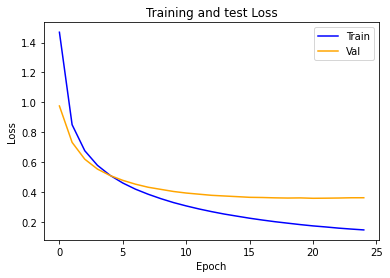

In [25]:
def plot_history(history): 
  """
  Plot the graph with training and test loss
  
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  _ = plt.figure()

  plt.title("Training and test Loss")
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
    
plot_history(history)

## Evaluation of Best model on the Test Set

In [ ]:
# Evaluation on the Test Set
bleu_score, sari_score = evaluate_model(transformer, TEST_PAIRS, word_tk_mem)

In [ ]:
print(f"Bleu score: {bleu_score['bleu']}")
print(f"Sari score: {sari_score['sari']}")

Bleu score: 0.34301430954549905
Sari score: 19.100196607914054


In [33]:
# We try our model on several test sentences in order to better visualize the predictions

test_texts = [pair[0] for pair in TEST_PAIRS]

for _ in range(15):
    input_sentence = random.choice(test_texts)
    print(convert_seq_to_text(input_sentence, IDX_TO_WORD))
    translated = decode_sequence(transformer, input_sentence, IDX_TO_WORD, WORD_TO_IDX)
    print(translated)
    print("\n")

la sintassi più semplice è quella seguente . 
[start] la sintassi è la seguente . [end]


è solo una mia opinione , ovviamente . 
[start] ovviamente è solo una mia opinione . [end]


cosa può dirme al riguardo ? 
[start] cosa puoi dire al riguardo ? [end]


nell attesa di un urgentissimo riscontro , distinti saluti . 
[start] in attesa di un riscontro porgiamo distinti saluti . [end]


la ringrazio infinitamente per la cortese attenzione e porgo distinti saluti . 
[start] la ringrazio per l attenzione e le porgo distinti saluti . [end]


ma oramai la frittata era fatta . 
[start] ma la frittata è fatta . [end]


la differenziazione delle tematiche affrontate è più che buona mentre è accettabile la capacità dimostrata nell attivare nuovi filoni culturali . 
[start] la differenziazione delle tematiche affrontate è buona così come buona e così semplice è sufficiente ai fini della chiusura . [end]


non si può far finta di niente . 
[start] non possiamo far finta di niente . [end]


il com